# Image Segmentation Programming Activity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_dir = '/content/drive/My Drive/Colab Notebooks/Computer Vision/'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image in color mode
img = cv2.imread(img_dir + 'cards.png', cv2.IMREAD_COLOR)

Whole Image:


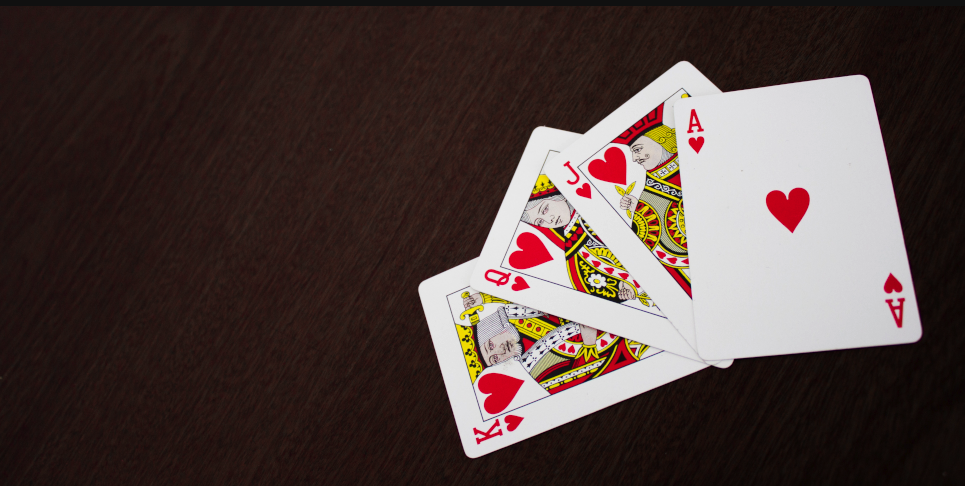

In [ ]:
from google.colab.patches import cv2_imshow
# Display the whole image
print("Whole Image:")
cv2_imshow(img)

In [ ]:
def my_read(filename):
    ' read from an image file to an rgb '
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def my_read_cg(filename):
    ' read from an image file to an rgb and a grayscale image array '
    rgb = my_read(filename)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return rgb, gray

def my_read_hsv(filename):
   img = cv2.imread(filename)
   return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def my_read_gray(filename):
    img = cv2.imread(filename,0)
    return img

def my_show(ax, img, title=None, interpolation='bicubic', **kwargs):
    ' helper to display an image on an axes without grid/spine '
    ax.imshow(img, interpolation = interpolation, **kwargs)
    ax.axis('off')
    if title:
        ax.set_title(title)

def my_gshow(ax, img, title=None, cmap='gray', interpolation='bicubic', **kwargs):
    ' helper to display an image, in grayscale, on an axes without grid/spine '
    my_show(ax, img, title=title, cmap='gray', interpolation=interpolation, **kwargs)

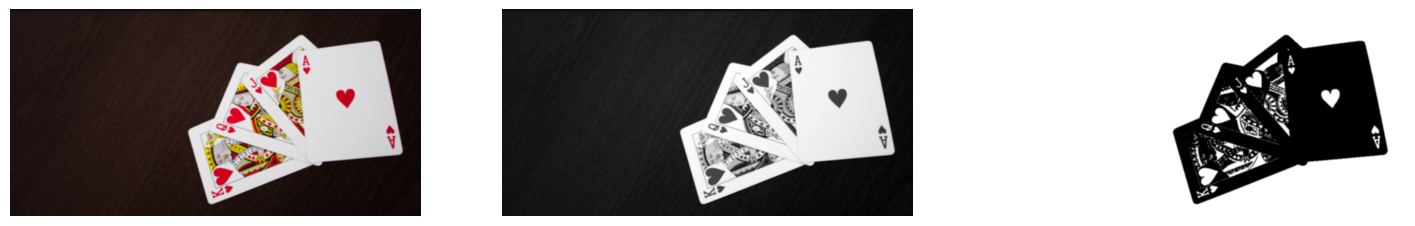

In [ ]:
cards, cards_g = my_read_cg(img_dir +'cards.png')
_, thresh = cv2.threshold(cards_g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

fig, axes = plt.subplots(1,3,figsize=(18,14))
my_gshow(axes[0], cards)
my_gshow(axes[1], cards_g)
my_gshow(axes[2], thresh)

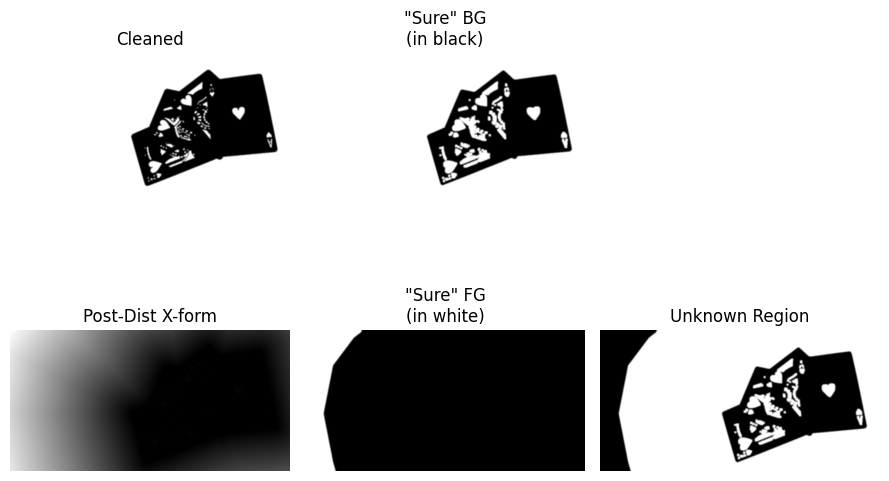

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations = 1)

# sure background area
sure_bg = cv2.dilate(cleaned, kernel,iterations=2)

# Finding sure foreground area (regions that are far from black)
dist_transform = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
sure_fg = cv2.threshold(dist_transform, 
                        0.7*dist_transform.max(), 255, 0)[1].astype(np.uint8)

# Finding unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

fig, axes = plt.subplots(2,3, figsize=(9,6))
my_gshow(axes[0,0], cleaned)
my_gshow(axes[0,1], sure_bg)
axes[0,2].set_visible(False)

axes[0,0].set_title('Cleaned')
axes[0,1].set_title('"Sure" BG\n(in black)')

my_gshow(axes[1,0], dist_transform)
my_gshow(axes[1,1], sure_fg)
my_gshow(axes[1,2], unknown)

axes[1,0].set_title("Post-Dist X-form")
axes[1,1].set_title('"Sure" FG\n(in white)')
axes[1,2].set_title('Unknown Region')

fig.tight_layout()

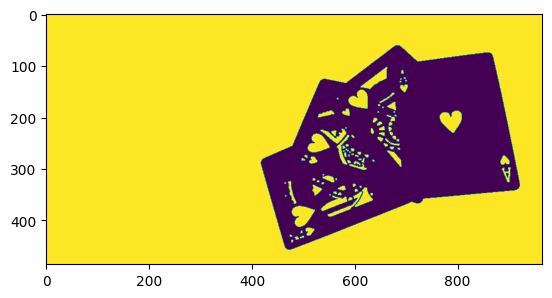

In [ ]:
plt.imshow(cleaned)

Found 3 pseudo-objects (connected components)


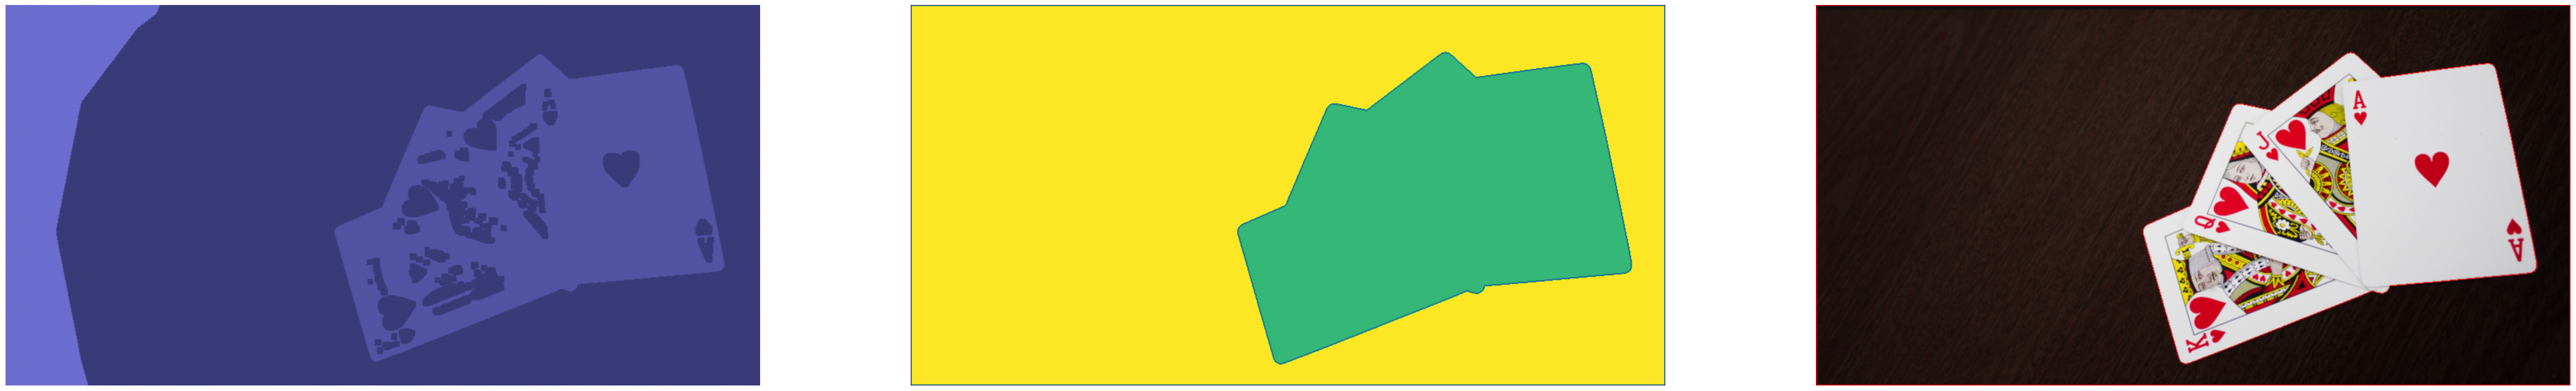

In [ ]:
# known connected components (bg 0, components 1+) --> bg 1, components 2+
markers = cv2.connectedComponents(sure_fg)[1] + 1
markers[unknown==255] = 0 # enforce this brutally
obj_ct = len(set(markers.flat))

print("Found", obj_ct, "pseudo-objects (connected components)")

def magic(idx):
    ' create a custom color mapping to take marker # --> good color '
    cmap = plt.cm.tab20b if idx < 20 else plt.cm.tab20c
    idx = idx if idx < 20 else idx - 20
    return cmap(idx)
magic_table   = np.array([magic(i) for i in range(obj_ct)])

fig, axes = plt.subplots(1,3,figsize=(60,30))
my_show(axes[0], magic_table[markers])  # full array indexes back into color table

watershed = cv2.watershed(cards, markers) # apply watershed to cards from "markers" seeds 
cards[markers == -1] = [255,0,0] # ^^^ markers is modified; -1 is boundaries

my_show(axes[1], watershed)
my_show(axes[2], cards)

# Note: you might like to compare this with hough circle transform on the same image

In [ ]:
#Grabcut

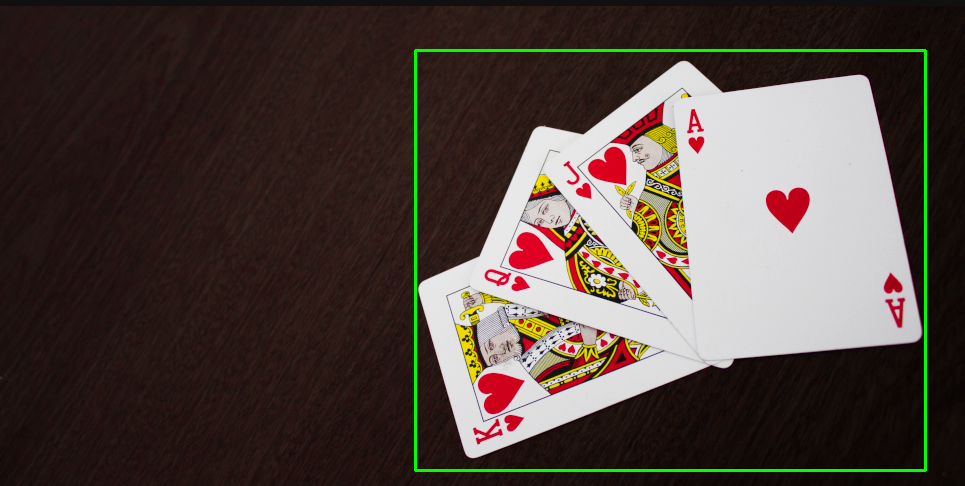

In [ ]:
# Make a copy of the image
img_draw = img.copy()

# The values are: start x, start y, width, height
rect = (415,50,510,420)

# Draw the rectangle on the copy of the image
cv2.rectangle(img_draw, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 2)

# Display the image with the rectangle
cv2_imshow(img_draw)

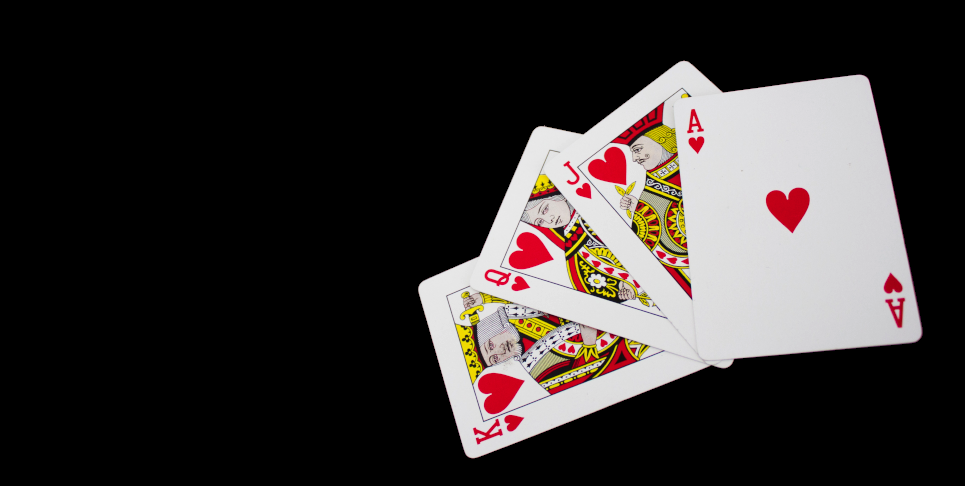

In [ ]:
# Run GrabCut
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

img = img*mask2[:,:,np.newaxis]

# Display the image
cv2_imshow(img)